# Writing a class to store tick data

In [1]:
class TickData(object):
	""" Stores a single unit of data """

	def __init__(self, timestamp='', symbol='',
				open_price=0, close_price=0, total_volume=0):
		self.symbol = symbol
		self.timestamp = timestamp
		self.open_price = open_price
		self.close_price = close_price
		self.total_volume = total_volume

# Writing a class to store market data

In [2]:
class MarketData(object):
	def __init__(self):
		self.recent_ticks = dict()  # indexed by symbol

	def add_tick_data(self, tick_data):
		self.recent_ticks[tick_data.symbol] = tick_data

	def get_open_price(self, symbol):
		return self.get_tick_data(symbol).open_price

	def get_close_price(self, symbol):
		return self.get_tick_data(symbol).close_price

	def get_tick_data(self, symbol):
		return self.recent_ticks.get(symbol, TickData())

	def get_timestamp(self, symbol):
		return self.recent_ticks[symbol].timestamp

# Writing a class to generate sources of market data

In [3]:
class MarketDataSource(object):
    def __init__(self, symbol, tick_event_handler=None, start='', end=''):
        self.market_data = MarketData()

        self.symbol = symbol
        self.tick_event_handler = tick_event_handler
        self.start, self.end = start, end
        self.df = None

    def fetch_historical_prices(self):
        import quandl

        # Update your Quandl API key here...
        QUANDL_API_KEY = 'BCzkk3NDWt7H9yjzx-DY'
        quandl.ApiConfig.api_key = QUANDL_API_KEY
        df = quandl.get(self.symbol, start_date=self.start, end_date=self.end)
        return df

    def run(self):
        if self.df is None:
            self.df = self.fetch_historical_prices()

        total_ticks = len(self.df)
        print('Processing total_ticks:', total_ticks)

        for timestamp, row in self.df.iterrows():
            open_price = row['Open']
            close_price = row['Close']
            volume = row['Volume']

            print(timestamp.date(), 'TICK', self.symbol,
                  'open:', open_price,
                  'close:', close_price)
            tick_data = TickData(timestamp, self.symbol, open_price,
                                close_price, volume)
            self.market_data.add_tick_data(tick_data)

            if self.tick_event_handler:
                self.tick_event_handler(self.market_data)

# Writing the order class

In [4]:
class Order(object):
	def __init__(self, timestamp, symbol, 
		qty, is_buy, is_market_order, 
		price=0
	):
		self.timestamp = timestamp
		self.symbol = symbol
		self.qty = qty
		self.price = price
		self.is_buy = is_buy
		self.is_market_order = is_market_order
		self.is_filled = False
		self.filled_price = 0
		self.filled_time = None
		self.filled_qty = 0

# Writing a class to keep track of positions

In [5]:
class Position(object):
	def __init__(self, symbol=''):
		self.symbol = symbol
		self.buys = self.sells = self.net = 0
		self.rpnl = 0
		self.position_value = 0

	def on_position_event(self, is_buy, qty, price):
		if is_buy:
			self.buys += qty
		else:
			self.sells += qty

		self.net = self.buys - self.sells
		changed_value = qty * price * (-1 if is_buy else 1)
		self.position_value += changed_value

		if self.net == 0:
			self.rpnl = self.position_value
			self.position_value = 0

	def calculate_unrealized_pnl(self, price):
		if self.net == 0:
			return 0

		market_value = self.net * price
		upnl = self.position_value + market_value
		return upnl

# Writing an abstract strategy class

In [6]:
from abc import abstractmethod

class Strategy:
	def __init__(self, send_order_event_handler):
		self.send_order_event_handler = send_order_event_handler

	@abstractmethod
	def on_tick_event(self, market_data):
		raise NotImplementedError('Method is required!')

	@abstractmethod
	def on_position_event(self, positions):
		raise NotImplementedError('Method is required!')

	def send_market_order(self, symbol, qty, is_buy, timestamp):
		if self.send_order_event_handler:
			order = Order(
				timestamp,
				symbol,
				qty,
				is_buy,
				is_market_order=True,
				price=0,
			)
			self.send_order_event_handler(order)

# Writing a mean-reverting strategy class

In [7]:
import pandas as pd

class MeanRevertingStrategy(Strategy):
    def __init__(self, symbol, trade_qty,
        send_order_event_handler=None, lookback_intervals=20,
        buy_threshold=-1.5, sell_threshold=1.5
    ):
        super(MeanRevertingStrategy, self).__init__(
            send_order_event_handler)

        self.symbol = symbol
        self.trade_qty = trade_qty
        self.lookback_intervals = lookback_intervals
        self.buy_threshold = buy_threshold
        self.sell_threshold = sell_threshold

        self.prices = pd.DataFrame()
        self.is_long = self.is_short = False

    def on_position_event(self, positions):
        position = positions.get(self.symbol)

        self.is_long = position and position.net > 0
        self.is_short = position and position.net < 0

    def on_tick_event(self, market_data):
        self.store_prices(market_data)

        if len(self.prices) < self.lookback_intervals:
            return

        self.generate_signals_and_send_order(market_data)

    def store_prices(self, market_data):
        timestamp = market_data.get_timestamp(self.symbol)
        close_price = market_data.get_close_price(self.symbol)
        self.prices.loc[timestamp, 'close'] = close_price

    def generate_signals_and_send_order(self, market_data):
        signal_value = self.calculate_z_score()
        timestamp = market_data.get_timestamp(self.symbol)

        if self.buy_threshold > signal_value and not self.is_long:
            print(timestamp.date(), 'BUY signal')
            self.send_market_order(
                self.symbol, self.trade_qty, True, timestamp)
        elif self.sell_threshold < signal_value and not self.is_short:
            print(timestamp.date(), 'SELL signal')
            self.send_market_order(
                self.symbol, self.trade_qty, False, timestamp)

    def calculate_z_score(self):
        self.prices = self.prices[-self.lookback_intervals:]
        returns = self.prices['close'].pct_change().dropna()
        z_score = ((returns - returns.mean()) / returns.std())[-1]
        return z_score

# Binding our modules with a backtesting engine

In [8]:
class BacktestEngine:
	def __init__(self, symbol, trade_qty, start='', end=''):
		self.symbol = symbol
		self.trade_qty = trade_qty
		self.market_data_source = MarketDataSource(
			symbol,
			tick_event_handler=self.on_tick_event,
			start=start, end=end
		)

		self.strategy = None
		self.unfilled_orders = []
		self.positions = dict()
		self.df_rpnl = None
        
	def start(self, **kwargs):
		print('Backtest started...')

		self.unfilled_orders = []
		self.positions = dict()
		self.df_rpnl = pd.DataFrame()

		self.strategy = MeanRevertingStrategy(
			self.symbol,
			self.trade_qty,
			send_order_event_handler=self.on_order_received,
			**kwargs
		)
		self.market_data_source.run()

		print('Backtest completed.')
        
	def on_order_received(self, order):
		""" Adds an order to the order book """
		print(
			order.timestamp.date(),
			'ORDER',
			'BUY' if order.is_buy else 'SELL',
			order.symbol,
			order.qty
		)
		self.unfilled_orders.append(order)
        
	def on_tick_event(self, market_data):
		self.match_order_book(market_data)
		self.strategy.on_tick_event(market_data)
		self.print_position_status(market_data)
        
	def match_order_book(self, market_data):
		if len(self.unfilled_orders) > 0:
			self.unfilled_orders = [
				order for order in self.unfilled_orders
				if self.match_unfilled_orders(order, market_data)
			]
            
	def match_unfilled_orders(self, order, market_data):
		symbol = order.symbol
		timestamp = market_data.get_timestamp(symbol)

		""" Order is matched and filled """
		if order.is_market_order and timestamp > order.timestamp:
			open_price = market_data.get_open_price(symbol)

			order.is_filled = True
			order.filled_timestamp = timestamp
			order.filled_price = open_price

			self.on_order_filled(
				symbol, order.qty, order.is_buy,
				open_price, timestamp
			)
			return False

		return True
    
	def on_order_filled(self, symbol, qty, is_buy, filled_price, timestamp):
		position = self.get_position(symbol)
		position.on_position_event(is_buy, qty, filled_price)
		self.df_rpnl.loc[timestamp, "rpnl"] = position.rpnl

		self.strategy.on_position_event(self.positions)

		print(
			timestamp.date(),
			'FILLED', "BUY" if is_buy else "SELL",
			qty, symbol, 'at', filled_price
		)
        
	def get_position(self, symbol):
		if symbol not in self.positions:
			self.positions[symbol] = Position(symbol)

		return self.positions[symbol]
    
	def print_position_status(self, market_data):
		for symbol, position in self.positions.items():
			close_price = market_data.get_close_price(symbol)
			timestamp = market_data.get_timestamp(symbol)

			upnl = position.calculate_unrealized_pnl(close_price)

			print(
				timestamp.date(),
				'POSITION',
				'value:%.3f' % position.position_value,
				'upnl:%.3f' % upnl,
				'rpnl:%.3f' % position.rpnl
			)

# Running our backtesting engine

In [9]:
engine = BacktestEngine(
    'WIKI/AAPL', 1,
    start='2015-01-01',
    end='2017-12-31'
)

In [10]:
engine.start(
    lookback_intervals=20,
    buy_threshold=-1.5,
    sell_threshold=1.5
)

Backtest started...
Processing total_ticks: 753
2015-01-02 TICK WIKI/AAPL open: 111.39 close: 109.33
2015-01-05 TICK WIKI/AAPL open: 108.29 close: 106.25
2015-01-06 TICK WIKI/AAPL open: 106.54 close: 106.26
2015-01-07 TICK WIKI/AAPL open: 107.2 close: 107.75
2015-01-08 TICK WIKI/AAPL open: 109.23 close: 111.89
2015-01-09 TICK WIKI/AAPL open: 112.67 close: 112.01
2015-01-12 TICK WIKI/AAPL open: 112.6 close: 109.25
2015-01-13 TICK WIKI/AAPL open: 111.43 close: 110.22
2015-01-14 TICK WIKI/AAPL open: 109.04 close: 109.8
2015-01-15 TICK WIKI/AAPL open: 110.0 close: 106.82
2015-01-16 TICK WIKI/AAPL open: 107.03 close: 105.99
2015-01-20 TICK WIKI/AAPL open: 107.84 close: 108.72
2015-01-21 TICK WIKI/AAPL open: 108.95 close: 109.55
2015-01-22 TICK WIKI/AAPL open: 110.26 close: 112.4
2015-01-23 TICK WIKI/AAPL open: 112.3 close: 112.98
2015-01-26 TICK WIKI/AAPL open: 113.74 close: 113.1
2015-01-27 TICK WIKI/AAPL open: 112.42 close: 109.14
2015-01-28 TICK WIKI/AAPL open: 117.625 close: 115.31
2015

2015-05-21 POSITION value:-126.560 upnl:4.830 rpnl:3.400
2015-05-22 TICK WIKI/AAPL open: 131.6 close: 132.54
2015-05-22 POSITION value:-126.560 upnl:5.980 rpnl:3.400
2015-05-26 TICK WIKI/AAPL open: 132.6 close: 129.62
2015-05-26 POSITION value:-126.560 upnl:3.060 rpnl:3.400
2015-05-27 TICK WIKI/AAPL open: 130.34 close: 132.045
2015-05-27 POSITION value:-126.560 upnl:5.485 rpnl:3.400
2015-05-28 TICK WIKI/AAPL open: 131.86 close: 131.78
2015-05-28 POSITION value:-126.560 upnl:5.220 rpnl:3.400
2015-05-29 TICK WIKI/AAPL open: 131.23 close: 130.28
2015-05-29 POSITION value:-126.560 upnl:3.720 rpnl:3.400
2015-06-01 TICK WIKI/AAPL open: 131.2 close: 130.535
2015-06-01 POSITION value:-126.560 upnl:3.975 rpnl:3.400
2015-06-02 TICK WIKI/AAPL open: 129.86 close: 129.96
2015-06-02 POSITION value:-126.560 upnl:3.400 rpnl:3.400
2015-06-03 TICK WIKI/AAPL open: 130.66 close: 130.12
2015-06-03 POSITION value:-126.560 upnl:3.560 rpnl:3.400
2015-06-04 TICK WIKI/AAPL open: 129.58 close: 129.36
2015-06-04 

2015-09-18 POSITION value:0.000 upnl:0.000 rpnl:-0.280
2015-09-21 TICK WIKI/AAPL open: 113.67 close: 115.21
2015-09-21 POSITION value:0.000 upnl:0.000 rpnl:-0.280
2015-09-22 TICK WIKI/AAPL open: 113.38 close: 113.4
2015-09-22 POSITION value:0.000 upnl:0.000 rpnl:-0.280
2015-09-23 TICK WIKI/AAPL open: 113.63 close: 114.32
2015-09-23 POSITION value:0.000 upnl:0.000 rpnl:-0.280
2015-09-24 TICK WIKI/AAPL open: 113.25 close: 115.0
2015-09-24 POSITION value:0.000 upnl:0.000 rpnl:-0.280
2015-09-25 TICK WIKI/AAPL open: 116.44 close: 114.71
2015-09-25 POSITION value:0.000 upnl:0.000 rpnl:-0.280
2015-09-28 TICK WIKI/AAPL open: 113.85 close: 112.44
2015-09-28 POSITION value:0.000 upnl:0.000 rpnl:-0.280
2015-09-29 TICK WIKI/AAPL open: 112.83 close: 109.06
2015-09-29 BUY signal
2015-09-29 ORDER BUY WIKI/AAPL 1
2015-09-29 POSITION value:0.000 upnl:0.000 rpnl:-0.280
2015-09-30 TICK WIKI/AAPL open: 110.17 close: 109.95
2015-09-30 FILLED BUY 1 WIKI/AAPL at 110.17
2015-09-30 POSITION value:-110.170 upnl

2015-12-31 POSITION value:0.000 upnl:0.000 rpnl:6.800
2016-01-04 TICK WIKI/AAPL open: 102.61 close: 105.35
2016-01-04 POSITION value:0.000 upnl:0.000 rpnl:6.800
2016-01-05 TICK WIKI/AAPL open: 105.75 close: 102.71
2016-01-05 POSITION value:0.000 upnl:0.000 rpnl:6.800
2016-01-06 TICK WIKI/AAPL open: 100.56 close: 100.7
2016-01-06 POSITION value:0.000 upnl:0.000 rpnl:6.800
2016-01-07 TICK WIKI/AAPL open: 98.68 close: 96.45
2016-01-07 BUY signal
2016-01-07 ORDER BUY WIKI/AAPL 1
2016-01-07 POSITION value:0.000 upnl:0.000 rpnl:6.800
2016-01-08 TICK WIKI/AAPL open: 98.55 close: 96.96
2016-01-08 FILLED BUY 1 WIKI/AAPL at 98.55
2016-01-08 POSITION value:-98.550 upnl:-1.590 rpnl:6.800
2016-01-11 TICK WIKI/AAPL open: 98.97 close: 98.53
2016-01-11 POSITION value:-98.550 upnl:-0.020 rpnl:6.800
2016-01-12 TICK WIKI/AAPL open: 100.55 close: 99.96
2016-01-12 POSITION value:-98.550 upnl:1.410 rpnl:6.800
2016-01-13 TICK WIKI/AAPL open: 100.32 close: 97.39
2016-01-13 POSITION value:-98.550 upnl:-1.160 r

2016-04-27 POSITION value:-108.910 upnl:-11.090 rpnl:-1.580
2016-04-28 TICK WIKI/AAPL open: 97.61 close: 94.83
2016-04-28 POSITION value:-108.910 upnl:-14.080 rpnl:-1.580
2016-04-29 TICK WIKI/AAPL open: 93.99 close: 93.74
2016-04-29 POSITION value:-108.910 upnl:-15.170 rpnl:-1.580
2016-05-02 TICK WIKI/AAPL open: 93.965 close: 93.64
2016-05-02 POSITION value:-108.910 upnl:-15.270 rpnl:-1.580
2016-05-03 TICK WIKI/AAPL open: 94.2 close: 95.18
2016-05-03 POSITION value:-108.910 upnl:-13.730 rpnl:-1.580
2016-05-04 TICK WIKI/AAPL open: 95.2 close: 94.19
2016-05-04 POSITION value:-108.910 upnl:-14.720 rpnl:-1.580
2016-05-05 TICK WIKI/AAPL open: 94.0 close: 93.24
2016-05-05 POSITION value:-108.910 upnl:-15.670 rpnl:-1.580
2016-05-06 TICK WIKI/AAPL open: 93.37 close: 92.72
2016-05-06 POSITION value:-108.910 upnl:-16.190 rpnl:-1.580
2016-05-09 TICK WIKI/AAPL open: 93.0 close: 92.79
2016-05-09 POSITION value:-108.910 upnl:-16.120 rpnl:-1.580
2016-05-10 TICK WIKI/AAPL open: 93.33 close: 93.42
2016

2016-08-10 POSITION value:102.830 upnl:-5.170 rpnl:2.100
2016-08-11 TICK WIKI/AAPL open: 108.52 close: 107.93
2016-08-11 POSITION value:102.830 upnl:-5.100 rpnl:2.100
2016-08-12 TICK WIKI/AAPL open: 107.78 close: 108.18
2016-08-12 POSITION value:102.830 upnl:-5.350 rpnl:2.100
2016-08-15 TICK WIKI/AAPL open: 108.14 close: 109.48
2016-08-15 POSITION value:102.830 upnl:-6.650 rpnl:2.100
2016-08-16 TICK WIKI/AAPL open: 109.63 close: 109.38
2016-08-16 POSITION value:102.830 upnl:-6.550 rpnl:2.100
2016-08-17 TICK WIKI/AAPL open: 109.1 close: 109.22
2016-08-17 POSITION value:102.830 upnl:-6.390 rpnl:2.100
2016-08-18 TICK WIKI/AAPL open: 109.23 close: 109.08
2016-08-18 POSITION value:102.830 upnl:-6.250 rpnl:2.100
2016-08-19 TICK WIKI/AAPL open: 108.77 close: 109.36
2016-08-19 POSITION value:102.830 upnl:-6.530 rpnl:2.100
2016-08-22 TICK WIKI/AAPL open: 108.86 close: 108.51
2016-08-22 POSITION value:102.830 upnl:-5.680 rpnl:2.100
2016-08-23 TICK WIKI/AAPL open: 108.59 close: 108.85
2016-08-23 

2016-11-29 POSITION value:0.000 upnl:0.000 rpnl:2.890
2016-11-30 TICK WIKI/AAPL open: 111.56 close: 110.52
2016-11-30 POSITION value:0.000 upnl:0.000 rpnl:2.890
2016-12-01 TICK WIKI/AAPL open: 110.365 close: 109.49
2016-12-01 POSITION value:0.000 upnl:0.000 rpnl:2.890
2016-12-02 TICK WIKI/AAPL open: 109.17 close: 109.9
2016-12-02 POSITION value:0.000 upnl:0.000 rpnl:2.890
2016-12-05 TICK WIKI/AAPL open: 110.0 close: 109.11
2016-12-05 POSITION value:0.000 upnl:0.000 rpnl:2.890
2016-12-06 TICK WIKI/AAPL open: 109.5 close: 109.95
2016-12-06 POSITION value:0.000 upnl:0.000 rpnl:2.890
2016-12-07 TICK WIKI/AAPL open: 109.26 close: 111.03
2016-12-07 POSITION value:0.000 upnl:0.000 rpnl:2.890
2016-12-08 TICK WIKI/AAPL open: 110.86 close: 112.12
2016-12-08 POSITION value:0.000 upnl:0.000 rpnl:2.890
2016-12-09 TICK WIKI/AAPL open: 112.31 close: 113.95
2016-12-09 POSITION value:0.000 upnl:0.000 rpnl:2.890
2016-12-12 TICK WIKI/AAPL open: 113.29 close: 113.3
2016-12-12 POSITION value:0.000 upnl:0.0

2017-03-23 POSITION value:-139.845 upnl:1.075 rpnl:-17.110
2017-03-24 TICK WIKI/AAPL open: 141.5 close: 140.64
2017-03-24 POSITION value:-139.845 upnl:0.795 rpnl:-17.110
2017-03-27 TICK WIKI/AAPL open: 139.39 close: 140.88
2017-03-27 POSITION value:-139.845 upnl:1.035 rpnl:-17.110
2017-03-28 TICK WIKI/AAPL open: 140.91 close: 143.8
2017-03-28 SELL signal
2017-03-28 ORDER SELL WIKI/AAPL 1
2017-03-28 POSITION value:-139.845 upnl:3.955 rpnl:-17.110
2017-03-29 TICK WIKI/AAPL open: 143.68 close: 144.12
2017-03-29 FILLED SELL 1 WIKI/AAPL at 143.68
2017-03-29 POSITION value:0.000 upnl:0.000 rpnl:3.835
2017-03-30 TICK WIKI/AAPL open: 144.19 close: 143.93
2017-03-30 POSITION value:0.000 upnl:0.000 rpnl:3.835
2017-03-31 TICK WIKI/AAPL open: 143.72 close: 143.66
2017-03-31 POSITION value:0.000 upnl:0.000 rpnl:3.835
2017-04-03 TICK WIKI/AAPL open: 143.71 close: 143.7
2017-04-03 POSITION value:0.000 upnl:0.000 rpnl:3.835
2017-04-04 TICK WIKI/AAPL open: 143.25 close: 144.77
2017-04-04 POSITION value

2017-07-14 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-07-17 TICK WIKI/AAPL open: 148.82 close: 149.56
2017-07-17 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-07-18 TICK WIKI/AAPL open: 149.2 close: 150.08
2017-07-18 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-07-19 TICK WIKI/AAPL open: 150.48 close: 151.02
2017-07-19 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-07-20 TICK WIKI/AAPL open: 151.5 close: 150.34
2017-07-20 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-07-21 TICK WIKI/AAPL open: 149.99 close: 150.27
2017-07-21 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-07-24 TICK WIKI/AAPL open: 150.58 close: 152.09
2017-07-24 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-07-25 TICK WIKI/AAPL open: 151.8 close: 152.74
2017-07-25 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-07-26 TICK WIKI/AAPL open: 153.35 close: 153.46
2017-07-26 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-07-27 TICK WIKI/AAPL open: 153.75 close: 150.56
2017-07-27 BUY signal
2017-07-27 ORDER B

2017-11-03 POSITION value:163.890 upnl:-8.610 rpnl:3.170
2017-11-06 TICK WIKI/AAPL open: 172.365 close: 174.25
2017-11-06 POSITION value:163.890 upnl:-10.360 rpnl:3.170
2017-11-07 TICK WIKI/AAPL open: 173.91 close: 174.81
2017-11-07 POSITION value:163.890 upnl:-10.920 rpnl:3.170
2017-11-09 TICK WIKI/AAPL open: 175.11 close: 175.88
2017-11-09 POSITION value:163.890 upnl:-11.990 rpnl:3.170
2017-11-10 TICK WIKI/AAPL open: 175.11 close: 174.67
2017-11-10 POSITION value:163.890 upnl:-10.780 rpnl:3.170
2017-11-13 TICK WIKI/AAPL open: 173.5 close: 173.97
2017-11-13 POSITION value:163.890 upnl:-10.080 rpnl:3.170
2017-11-14 TICK WIKI/AAPL open: 173.04 close: 171.34
2017-11-14 POSITION value:163.890 upnl:-7.450 rpnl:3.170
2017-11-15 TICK WIKI/AAPL open: 169.97 close: 169.08
2017-11-15 POSITION value:163.890 upnl:-5.190 rpnl:3.170
2017-11-16 TICK WIKI/AAPL open: 171.18 close: 171.1
2017-11-16 POSITION value:163.890 upnl:-7.210 rpnl:3.170
2017-11-17 TICK WIKI/AAPL open: 171.04 close: 170.15
2017-1

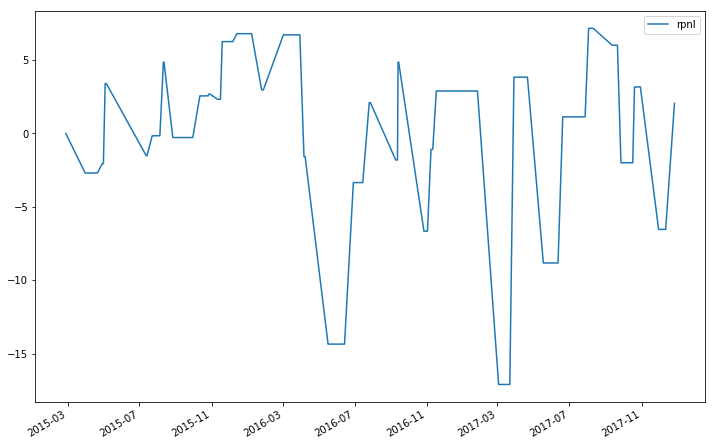

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

engine.df_rpnl.plot(figsize=(12, 8));

# Multiple runs of the backtest engine

In [13]:
THRESHOLDS = [
    (-0.5, 0.5),
    (-1.5, 1.5),
    (-2.5, 2.0),
    (-1.5, 2.5),
]

Backtest started...
Processing total_ticks: 753
2015-01-02 TICK WIKI/AAPL open: 111.39 close: 109.33
2015-01-05 TICK WIKI/AAPL open: 108.29 close: 106.25
2015-01-06 TICK WIKI/AAPL open: 106.54 close: 106.26
2015-01-07 TICK WIKI/AAPL open: 107.2 close: 107.75
2015-01-08 TICK WIKI/AAPL open: 109.23 close: 111.89
2015-01-09 TICK WIKI/AAPL open: 112.67 close: 112.01
2015-01-12 TICK WIKI/AAPL open: 112.6 close: 109.25
2015-01-13 TICK WIKI/AAPL open: 111.43 close: 110.22
2015-01-14 TICK WIKI/AAPL open: 109.04 close: 109.8
2015-01-15 TICK WIKI/AAPL open: 110.0 close: 106.82
2015-01-16 TICK WIKI/AAPL open: 107.03 close: 105.99
2015-01-20 TICK WIKI/AAPL open: 107.84 close: 108.72
2015-01-21 TICK WIKI/AAPL open: 108.95 close: 109.55
2015-01-22 TICK WIKI/AAPL open: 110.26 close: 112.4
2015-01-23 TICK WIKI/AAPL open: 112.3 close: 112.98
2015-01-26 TICK WIKI/AAPL open: 113.74 close: 113.1
2015-01-27 TICK WIKI/AAPL open: 112.42 close: 109.14
2015-01-28 TICK WIKI/AAPL open: 117.625 close: 115.31
2015

2015-04-15 POSITION value:125.950 upnl:-0.830 rpnl:-1.380
2015-04-16 TICK WIKI/AAPL open: 126.28 close: 126.17
2015-04-16 POSITION value:125.950 upnl:-0.220 rpnl:-1.380
2015-04-17 TICK WIKI/AAPL open: 125.55 close: 124.75
2015-04-17 BUY signal
2015-04-17 ORDER BUY WIKI/AAPL 1
2015-04-17 POSITION value:125.950 upnl:1.200 rpnl:-1.380
2015-04-20 TICK WIKI/AAPL open: 125.57 close: 127.6
2015-04-20 FILLED BUY 1 WIKI/AAPL at 125.57
2015-04-20 SELL signal
2015-04-20 ORDER SELL WIKI/AAPL 1
2015-04-20 POSITION value:0.000 upnl:0.000 rpnl:0.380
2015-04-21 TICK WIKI/AAPL open: 128.1 close: 126.91
2015-04-21 FILLED SELL 1 WIKI/AAPL at 128.1
2015-04-21 POSITION value:128.100 upnl:1.190 rpnl:0.380
2015-04-22 TICK WIKI/AAPL open: 126.99 close: 128.62
2015-04-22 POSITION value:128.100 upnl:-0.520 rpnl:0.380
2015-04-23 TICK WIKI/AAPL open: 128.3 close: 129.67
2015-04-23 POSITION value:128.100 upnl:-1.570 rpnl:0.380
2015-04-24 TICK WIKI/AAPL open: 130.49 close: 130.28
2015-04-24 POSITION value:128.100 u

2015-07-01 SELL signal
2015-07-01 ORDER SELL WIKI/AAPL 1
2015-07-01 POSITION value:0.000 upnl:0.000 rpnl:1.440
2015-07-02 TICK WIKI/AAPL open: 126.43 close: 126.44
2015-07-02 FILLED SELL 1 WIKI/AAPL at 126.43
2015-07-02 POSITION value:126.430 upnl:-0.010 rpnl:1.440
2015-07-06 TICK WIKI/AAPL open: 124.94 close: 126.0
2015-07-06 POSITION value:126.430 upnl:0.430 rpnl:1.440
2015-07-07 TICK WIKI/AAPL open: 125.89 close: 125.69
2015-07-07 POSITION value:126.430 upnl:0.740 rpnl:1.440
2015-07-08 TICK WIKI/AAPL open: 124.48 close: 122.57
2015-07-08 BUY signal
2015-07-08 ORDER BUY WIKI/AAPL 1
2015-07-08 POSITION value:126.430 upnl:3.860 rpnl:1.440
2015-07-09 TICK WIKI/AAPL open: 123.85 close: 120.07
2015-07-09 FILLED BUY 1 WIKI/AAPL at 123.85
2015-07-09 BUY signal
2015-07-09 ORDER BUY WIKI/AAPL 1
2015-07-09 POSITION value:0.000 upnl:0.000 rpnl:2.580
2015-07-10 TICK WIKI/AAPL open: 121.94 close: 123.28
2015-07-10 FILLED BUY 1 WIKI/AAPL at 121.94
2015-07-10 SELL signal
2015-07-10 ORDER SELL WIKI/

2015-10-01 TICK WIKI/AAPL open: 109.07 close: 109.58
2015-10-01 FILLED SELL 1 WIKI/AAPL at 109.07
2015-10-01 POSITION value:0.000 upnl:0.000 rpnl:-4.560
2015-10-02 TICK WIKI/AAPL open: 108.01 close: 110.38
2015-10-02 POSITION value:0.000 upnl:0.000 rpnl:-4.560
2015-10-05 TICK WIKI/AAPL open: 109.88 close: 110.78
2015-10-05 POSITION value:0.000 upnl:0.000 rpnl:-4.560
2015-10-06 TICK WIKI/AAPL open: 110.63 close: 111.31
2015-10-06 POSITION value:0.000 upnl:0.000 rpnl:-4.560
2015-10-07 TICK WIKI/AAPL open: 111.74 close: 110.78
2015-10-07 POSITION value:0.000 upnl:0.000 rpnl:-4.560
2015-10-08 TICK WIKI/AAPL open: 110.19 close: 109.5
2015-10-08 BUY signal
2015-10-08 ORDER BUY WIKI/AAPL 1
2015-10-08 POSITION value:0.000 upnl:0.000 rpnl:-4.560
2015-10-09 TICK WIKI/AAPL open: 110.0 close: 112.12
2015-10-09 FILLED BUY 1 WIKI/AAPL at 110.0
2015-10-09 SELL signal
2015-10-09 ORDER SELL WIKI/AAPL 1
2015-10-09 POSITION value:-110.000 upnl:2.120 rpnl:-4.560
2015-10-12 TICK WIKI/AAPL open: 112.73 clos

2015-12-30 TICK WIKI/AAPL open: 108.58 close: 107.32
2015-12-30 BUY signal
2015-12-30 ORDER BUY WIKI/AAPL 1
2015-12-30 POSITION value:109.000 upnl:1.680 rpnl:-1.510
2015-12-31 TICK WIKI/AAPL open: 107.01 close: 105.26
2015-12-31 FILLED BUY 1 WIKI/AAPL at 107.01
2015-12-31 BUY signal
2015-12-31 ORDER BUY WIKI/AAPL 1
2015-12-31 POSITION value:0.000 upnl:0.000 rpnl:1.990
2016-01-04 TICK WIKI/AAPL open: 102.61 close: 105.35
2016-01-04 FILLED BUY 1 WIKI/AAPL at 102.61
2016-01-04 SELL signal
2016-01-04 ORDER SELL WIKI/AAPL 1
2016-01-04 POSITION value:-102.610 upnl:2.740 rpnl:1.990
2016-01-05 TICK WIKI/AAPL open: 105.75 close: 102.71
2016-01-05 FILLED SELL 1 WIKI/AAPL at 105.75
2016-01-05 BUY signal
2016-01-05 ORDER BUY WIKI/AAPL 1
2016-01-05 POSITION value:0.000 upnl:0.000 rpnl:3.140
2016-01-06 TICK WIKI/AAPL open: 100.56 close: 100.7
2016-01-06 FILLED BUY 1 WIKI/AAPL at 100.56
2016-01-06 POSITION value:-100.560 upnl:0.140 rpnl:3.140
2016-01-07 TICK WIKI/AAPL open: 98.68 close: 96.45
2016-01

2016-03-17 FILLED SELL 1 WIKI/AAPL at 105.52
2016-03-17 BUY signal
2016-03-17 ORDER BUY WIKI/AAPL 1
2016-03-17 POSITION value:105.520 upnl:-0.280 rpnl:3.300
2016-03-18 TICK WIKI/AAPL open: 106.34 close: 105.92
2016-03-18 FILLED BUY 1 WIKI/AAPL at 106.34
2016-03-18 POSITION value:0.000 upnl:0.000 rpnl:-0.820
2016-03-21 TICK WIKI/AAPL open: 105.93 close: 105.91
2016-03-21 BUY signal
2016-03-21 ORDER BUY WIKI/AAPL 1
2016-03-21 POSITION value:0.000 upnl:0.000 rpnl:-0.820
2016-03-22 TICK WIKI/AAPL open: 105.25 close: 106.72
2016-03-22 FILLED BUY 1 WIKI/AAPL at 105.25
2016-03-22 POSITION value:-105.250 upnl:1.470 rpnl:-0.820
2016-03-23 TICK WIKI/AAPL open: 106.48 close: 106.13
2016-03-23 POSITION value:-105.250 upnl:0.880 rpnl:-0.820
2016-03-24 TICK WIKI/AAPL open: 105.47 close: 105.67
2016-03-24 POSITION value:-105.250 upnl:0.420 rpnl:-0.820
2016-03-28 TICK WIKI/AAPL open: 106.0 close: 105.19
2016-03-28 POSITION value:-105.250 upnl:-0.060 rpnl:-0.820
2016-03-29 TICK WIKI/AAPL open: 104.89 c

2016-06-15 TICK WIKI/AAPL open: 97.82 close: 97.14
2016-06-15 POSITION value:-97.600 upnl:-0.460 rpnl:-6.630
2016-06-16 TICK WIKI/AAPL open: 96.45 close: 97.55
2016-06-16 POSITION value:-97.600 upnl:-0.050 rpnl:-6.630
2016-06-17 TICK WIKI/AAPL open: 96.62 close: 95.33
2016-06-17 POSITION value:-97.600 upnl:-2.270 rpnl:-6.630
2016-06-20 TICK WIKI/AAPL open: 96.0 close: 95.1
2016-06-20 POSITION value:-97.600 upnl:-2.500 rpnl:-6.630
2016-06-21 TICK WIKI/AAPL open: 94.94 close: 95.91
2016-06-21 SELL signal
2016-06-21 ORDER SELL WIKI/AAPL 1
2016-06-21 POSITION value:-97.600 upnl:-1.690 rpnl:-6.630
2016-06-22 TICK WIKI/AAPL open: 96.25 close: 95.55
2016-06-22 FILLED SELL 1 WIKI/AAPL at 96.25
2016-06-22 POSITION value:0.000 upnl:0.000 rpnl:-1.350
2016-06-23 TICK WIKI/AAPL open: 95.94 close: 96.1
2016-06-23 SELL signal
2016-06-23 ORDER SELL WIKI/AAPL 1
2016-06-23 POSITION value:0.000 upnl:0.000 rpnl:-1.350
2016-06-24 TICK WIKI/AAPL open: 92.91 close: 93.4
2016-06-24 FILLED SELL 1 WIKI/AAPL at 

2016-09-09 POSITION value:0.000 upnl:0.000 rpnl:3.260
2016-09-12 TICK WIKI/AAPL open: 102.65 close: 105.44
2016-09-12 FILLED BUY 1 WIKI/AAPL at 102.65
2016-09-12 SELL signal
2016-09-12 ORDER SELL WIKI/AAPL 1
2016-09-12 POSITION value:-102.650 upnl:2.790 rpnl:3.260
2016-09-13 TICK WIKI/AAPL open: 107.51 close: 107.95
2016-09-13 FILLED SELL 1 WIKI/AAPL at 107.51
2016-09-13 SELL signal
2016-09-13 ORDER SELL WIKI/AAPL 1
2016-09-13 POSITION value:0.000 upnl:0.000 rpnl:4.860
2016-09-14 TICK WIKI/AAPL open: 108.73 close: 111.77
2016-09-14 FILLED SELL 1 WIKI/AAPL at 108.73
2016-09-14 POSITION value:108.730 upnl:-3.040 rpnl:4.860
2016-09-15 TICK WIKI/AAPL open: 113.86 close: 115.57
2016-09-15 POSITION value:108.730 upnl:-6.840 rpnl:4.860
2016-09-16 TICK WIKI/AAPL open: 115.12 close: 114.92
2016-09-16 BUY signal
2016-09-16 ORDER BUY WIKI/AAPL 1
2016-09-16 POSITION value:108.730 upnl:-6.190 rpnl:4.860
2016-09-19 TICK WIKI/AAPL open: 115.19 close: 113.58
2016-09-19 FILLED BUY 1 WIKI/AAPL at 115.19

2016-12-06 POSITION value:-109.170 upnl:0.780 rpnl:-3.665
2016-12-07 TICK WIKI/AAPL open: 109.26 close: 111.03
2016-12-07 FILLED SELL 1 WIKI/AAPL at 109.26
2016-12-07 SELL signal
2016-12-07 ORDER SELL WIKI/AAPL 1
2016-12-07 POSITION value:0.000 upnl:0.000 rpnl:0.090
2016-12-08 TICK WIKI/AAPL open: 110.86 close: 112.12
2016-12-08 FILLED SELL 1 WIKI/AAPL at 110.86
2016-12-08 POSITION value:110.860 upnl:-1.260 rpnl:0.090
2016-12-09 TICK WIKI/AAPL open: 112.31 close: 113.95
2016-12-09 POSITION value:110.860 upnl:-3.090 rpnl:0.090
2016-12-12 TICK WIKI/AAPL open: 113.29 close: 113.3
2016-12-12 BUY signal
2016-12-12 ORDER BUY WIKI/AAPL 1
2016-12-12 POSITION value:110.860 upnl:-2.440 rpnl:0.090
2016-12-13 TICK WIKI/AAPL open: 113.84 close: 115.19
2016-12-13 FILLED BUY 1 WIKI/AAPL at 113.84
2016-12-13 SELL signal
2016-12-13 ORDER SELL WIKI/AAPL 1
2016-12-13 POSITION value:0.000 upnl:0.000 rpnl:-2.980
2016-12-14 TICK WIKI/AAPL open: 115.04 close: 115.19
2016-12-14 FILLED SELL 1 WIKI/AAPL at 115.

2017-04-03 POSITION value:0.000 upnl:0.000 rpnl:2.180
2017-04-04 TICK WIKI/AAPL open: 143.25 close: 144.77
2017-04-04 SELL signal
2017-04-04 ORDER SELL WIKI/AAPL 1
2017-04-04 POSITION value:0.000 upnl:0.000 rpnl:2.180
2017-04-05 TICK WIKI/AAPL open: 144.22 close: 144.02
2017-04-05 FILLED SELL 1 WIKI/AAPL at 144.22
2017-04-05 BUY signal
2017-04-05 ORDER BUY WIKI/AAPL 1
2017-04-05 POSITION value:144.220 upnl:0.200 rpnl:2.180
2017-04-06 TICK WIKI/AAPL open: 144.29 close: 143.66
2017-04-06 FILLED BUY 1 WIKI/AAPL at 144.29
2017-04-06 BUY signal
2017-04-06 ORDER BUY WIKI/AAPL 1
2017-04-06 POSITION value:0.000 upnl:0.000 rpnl:-0.070
2017-04-07 TICK WIKI/AAPL open: 143.73 close: 143.34
2017-04-07 FILLED BUY 1 WIKI/AAPL at 143.73
2017-04-07 POSITION value:-143.730 upnl:-0.390 rpnl:-0.070
2017-04-10 TICK WIKI/AAPL open: 143.6 close: 143.17
2017-04-10 POSITION value:-143.730 upnl:-0.560 rpnl:-0.070
2017-04-11 TICK WIKI/AAPL open: 142.94 close: 141.63
2017-04-11 POSITION value:-143.730 upnl:-2.100

2017-06-26 POSITION value:145.770 upnl:-0.050 rpnl:3.550
2017-06-27 TICK WIKI/AAPL open: 145.01 close: 143.74
2017-06-27 BUY signal
2017-06-27 ORDER BUY WIKI/AAPL 1
2017-06-27 POSITION value:145.770 upnl:2.030 rpnl:3.550
2017-06-28 TICK WIKI/AAPL open: 144.49 close: 145.83
2017-06-28 FILLED BUY 1 WIKI/AAPL at 144.49
2017-06-28 SELL signal
2017-06-28 ORDER SELL WIKI/AAPL 1
2017-06-28 POSITION value:0.000 upnl:0.000 rpnl:1.280
2017-06-29 TICK WIKI/AAPL open: 144.71 close: 143.68
2017-06-29 FILLED SELL 1 WIKI/AAPL at 144.71
2017-06-29 BUY signal
2017-06-29 ORDER BUY WIKI/AAPL 1
2017-06-29 POSITION value:144.710 upnl:1.030 rpnl:1.280
2017-06-30 TICK WIKI/AAPL open: 144.45 close: 144.02
2017-06-30 FILLED BUY 1 WIKI/AAPL at 144.45
2017-06-30 POSITION value:0.000 upnl:0.000 rpnl:0.260
2017-07-03 TICK WIKI/AAPL open: 144.88 close: 143.5
2017-07-03 POSITION value:0.000 upnl:0.000 rpnl:0.260
2017-07-05 TICK WIKI/AAPL open: 143.69 close: 144.09
2017-07-05 SELL signal
2017-07-05 ORDER SELL WIKI/AA

2017-09-19 POSITION value:-159.510 upnl:-0.780 rpnl:1.120
2017-09-20 TICK WIKI/AAPL open: 157.9 close: 156.07
2017-09-20 POSITION value:-159.510 upnl:-3.440 rpnl:1.120
2017-09-21 TICK WIKI/AAPL open: 155.8 close: 153.39
2017-09-21 POSITION value:-159.510 upnl:-6.120 rpnl:1.120
2017-09-22 TICK WIKI/AAPL open: 152.02 close: 151.89
2017-09-22 POSITION value:-159.510 upnl:-7.620 rpnl:1.120
2017-09-25 TICK WIKI/AAPL open: 149.99 close: 150.55
2017-09-25 POSITION value:-159.510 upnl:-8.960 rpnl:1.120
2017-09-26 TICK WIKI/AAPL open: 151.78 close: 153.14
2017-09-26 SELL signal
2017-09-26 ORDER SELL WIKI/AAPL 1
2017-09-26 POSITION value:-159.510 upnl:-6.370 rpnl:1.120
2017-09-27 TICK WIKI/AAPL open: 153.8 close: 154.23
2017-09-27 FILLED SELL 1 WIKI/AAPL at 153.8
2017-09-27 SELL signal
2017-09-27 ORDER SELL WIKI/AAPL 1
2017-09-27 POSITION value:0.000 upnl:0.000 rpnl:-5.710
2017-09-28 TICK WIKI/AAPL open: 153.89 close: 153.28
2017-09-28 FILLED SELL 1 WIKI/AAPL at 153.89
2017-09-28 POSITION value:

2017-12-27 TICK WIKI/AAPL open: 170.1 close: 170.6
2017-12-27 FILLED BUY 1 WIKI/AAPL at 170.1
2017-12-27 POSITION value:-170.100 upnl:0.500 rpnl:0.160
2017-12-28 TICK WIKI/AAPL open: 171.0 close: 171.08
2017-12-28 POSITION value:-170.100 upnl:0.980 rpnl:0.160
2017-12-29 TICK WIKI/AAPL open: 170.52 close: 169.23
2017-12-29 POSITION value:-170.100 upnl:-0.870 rpnl:0.160
Backtest completed.
Backtest started...
Processing total_ticks: 753
2015-01-02 TICK WIKI/AAPL open: 111.39 close: 109.33
2015-01-05 TICK WIKI/AAPL open: 108.29 close: 106.25
2015-01-06 TICK WIKI/AAPL open: 106.54 close: 106.26
2015-01-07 TICK WIKI/AAPL open: 107.2 close: 107.75
2015-01-08 TICK WIKI/AAPL open: 109.23 close: 111.89
2015-01-09 TICK WIKI/AAPL open: 112.67 close: 112.01
2015-01-12 TICK WIKI/AAPL open: 112.6 close: 109.25
2015-01-13 TICK WIKI/AAPL open: 111.43 close: 110.22
2015-01-14 TICK WIKI/AAPL open: 109.04 close: 109.8
2015-01-15 TICK WIKI/AAPL open: 110.0 close: 106.82
2015-01-16 TICK WIKI/AAPL open: 107

2015-05-07 POSITION value:-126.560 upnl:-1.300 rpnl:3.400
2015-05-08 TICK WIKI/AAPL open: 126.68 close: 127.62
2015-05-08 POSITION value:-126.560 upnl:1.060 rpnl:3.400
2015-05-11 TICK WIKI/AAPL open: 127.39 close: 126.32
2015-05-11 POSITION value:-126.560 upnl:-0.240 rpnl:3.400
2015-05-12 TICK WIKI/AAPL open: 125.6 close: 125.865
2015-05-12 POSITION value:-126.560 upnl:-0.695 rpnl:3.400
2015-05-13 TICK WIKI/AAPL open: 126.15 close: 126.01
2015-05-13 POSITION value:-126.560 upnl:-0.550 rpnl:3.400
2015-05-14 TICK WIKI/AAPL open: 127.41 close: 128.95
2015-05-14 POSITION value:-126.560 upnl:2.390 rpnl:3.400
2015-05-15 TICK WIKI/AAPL open: 129.07 close: 128.77
2015-05-15 POSITION value:-126.560 upnl:2.210 rpnl:3.400
2015-05-18 TICK WIKI/AAPL open: 128.38 close: 130.19
2015-05-18 POSITION value:-126.560 upnl:3.630 rpnl:3.400
2015-05-19 TICK WIKI/AAPL open: 130.69 close: 130.07
2015-05-19 POSITION value:-126.560 upnl:3.510 rpnl:3.400
2015-05-20 TICK WIKI/AAPL open: 130.0 close: 130.06
2015-05

2015-08-26 TICK WIKI/AAPL open: 107.085 close: 109.69
2015-08-26 SELL signal
2015-08-26 ORDER SELL WIKI/AAPL 1
2015-08-26 POSITION value:-112.530 upnl:-2.840 rpnl:4.860
2015-08-27 TICK WIKI/AAPL open: 112.25 close: 112.92
2015-08-27 FILLED SELL 1 WIKI/AAPL at 112.25
2015-08-27 POSITION value:0.000 upnl:0.000 rpnl:-0.280
2015-08-28 TICK WIKI/AAPL open: 112.17 close: 113.29
2015-08-28 POSITION value:0.000 upnl:0.000 rpnl:-0.280
2015-08-31 TICK WIKI/AAPL open: 112.13 close: 112.76
2015-08-31 POSITION value:0.000 upnl:0.000 rpnl:-0.280
2015-09-01 TICK WIKI/AAPL open: 110.18 close: 107.72
2015-09-01 POSITION value:0.000 upnl:0.000 rpnl:-0.280
2015-09-02 TICK WIKI/AAPL open: 110.0 close: 112.34
2015-09-02 POSITION value:0.000 upnl:0.000 rpnl:-0.280
2015-09-03 TICK WIKI/AAPL open: 112.49 close: 110.37
2015-09-03 POSITION value:0.000 upnl:0.000 rpnl:-0.280
2015-09-04 TICK WIKI/AAPL open: 108.97 close: 109.27
2015-09-04 POSITION value:0.000 upnl:0.000 rpnl:-0.280
2015-09-08 TICK WIKI/AAPL open:

2015-12-07 POSITION value:118.980 upnl:0.700 rpnl:6.260
2015-12-08 TICK WIKI/AAPL open: 117.52 close: 118.23
2015-12-08 POSITION value:118.980 upnl:0.750 rpnl:6.260
2015-12-09 TICK WIKI/AAPL open: 117.64 close: 115.62
2015-12-09 POSITION value:118.980 upnl:3.360 rpnl:6.260
2015-12-10 TICK WIKI/AAPL open: 116.04 close: 116.17
2015-12-10 POSITION value:118.980 upnl:2.810 rpnl:6.260
2015-12-11 TICK WIKI/AAPL open: 115.19 close: 113.18
2015-12-11 BUY signal
2015-12-11 ORDER BUY WIKI/AAPL 1
2015-12-11 POSITION value:118.980 upnl:5.800 rpnl:6.260
2015-12-14 TICK WIKI/AAPL open: 112.18 close: 112.48
2015-12-14 FILLED BUY 1 WIKI/AAPL at 112.18
2015-12-14 POSITION value:0.000 upnl:0.000 rpnl:6.800
2015-12-15 TICK WIKI/AAPL open: 111.94 close: 110.49
2015-12-15 POSITION value:0.000 upnl:0.000 rpnl:6.800
2015-12-16 TICK WIKI/AAPL open: 111.07 close: 111.34
2015-12-16 POSITION value:0.000 upnl:0.000 rpnl:6.800
2015-12-17 TICK WIKI/AAPL open: 112.02 close: 108.98
2015-12-17 POSITION value:0.000 upn

2016-03-30 TICK WIKI/AAPL open: 108.65 close: 109.56
2016-03-30 FILLED SELL 1 WIKI/AAPL at 108.65
2016-03-30 POSITION value:108.650 upnl:-0.910 rpnl:6.720
2016-03-31 TICK WIKI/AAPL open: 109.72 close: 108.99
2016-03-31 POSITION value:108.650 upnl:-0.340 rpnl:6.720
2016-04-01 TICK WIKI/AAPL open: 108.78 close: 109.99
2016-04-01 POSITION value:108.650 upnl:-1.340 rpnl:6.720
2016-04-04 TICK WIKI/AAPL open: 110.42 close: 111.12
2016-04-04 POSITION value:108.650 upnl:-2.470 rpnl:6.720
2016-04-05 TICK WIKI/AAPL open: 109.51 close: 109.81
2016-04-05 BUY signal
2016-04-05 ORDER BUY WIKI/AAPL 1
2016-04-05 POSITION value:108.650 upnl:-1.160 rpnl:6.720
2016-04-06 TICK WIKI/AAPL open: 110.23 close: 110.96
2016-04-06 FILLED BUY 1 WIKI/AAPL at 110.23
2016-04-06 POSITION value:0.000 upnl:0.000 rpnl:-1.580
2016-04-07 TICK WIKI/AAPL open: 109.95 close: 108.54
2016-04-07 BUY signal
2016-04-07 ORDER BUY WIKI/AAPL 1
2016-04-07 POSITION value:0.000 upnl:0.000 rpnl:-1.580
2016-04-08 TICK WIKI/AAPL open: 108

2016-07-18 TICK WIKI/AAPL open: 98.7 close: 99.83
2016-07-18 POSITION value:98.920 upnl:-0.910 rpnl:-3.350
2016-07-19 TICK WIKI/AAPL open: 99.56 close: 99.87
2016-07-19 POSITION value:98.920 upnl:-0.950 rpnl:-3.350
2016-07-20 TICK WIKI/AAPL open: 100.0 close: 99.96
2016-07-20 POSITION value:98.920 upnl:-1.040 rpnl:-3.350
2016-07-21 TICK WIKI/AAPL open: 99.83 close: 99.43
2016-07-21 POSITION value:98.920 upnl:-0.510 rpnl:-3.350
2016-07-22 TICK WIKI/AAPL open: 99.26 close: 98.66
2016-07-22 POSITION value:98.920 upnl:0.260 rpnl:-3.350
2016-07-25 TICK WIKI/AAPL open: 98.25 close: 97.34
2016-07-25 BUY signal
2016-07-25 ORDER BUY WIKI/AAPL 1
2016-07-25 POSITION value:98.920 upnl:1.580 rpnl:-3.350
2016-07-26 TICK WIKI/AAPL open: 96.82 close: 96.67
2016-07-26 FILLED BUY 1 WIKI/AAPL at 96.82
2016-07-26 POSITION value:0.000 upnl:0.000 rpnl:2.100
2016-07-27 TICK WIKI/AAPL open: 104.265 close: 102.95
2016-07-27 SELL signal
2016-07-27 ORDER SELL WIKI/AAPL 1
2016-07-27 POSITION value:0.000 upnl:0.00

2016-11-01 TICK WIKI/AAPL open: 113.46 close: 111.49
2016-11-01 BUY signal
2016-11-01 ORDER BUY WIKI/AAPL 1
2016-11-01 POSITION value:0.000 upnl:0.000 rpnl:-6.660
2016-11-02 TICK WIKI/AAPL open: 111.4 close: 111.59
2016-11-02 FILLED BUY 1 WIKI/AAPL at 111.4
2016-11-02 POSITION value:-111.400 upnl:0.190 rpnl:-6.660
2016-11-03 TICK WIKI/AAPL open: 110.98 close: 109.83
2016-11-03 POSITION value:-111.400 upnl:-1.570 rpnl:-6.660
2016-11-04 TICK WIKI/AAPL open: 108.53 close: 108.84
2016-11-04 POSITION value:-111.400 upnl:-2.560 rpnl:-6.660
2016-11-07 TICK WIKI/AAPL open: 110.08 close: 110.41
2016-11-07 SELL signal
2016-11-07 ORDER SELL WIKI/AAPL 1
2016-11-07 POSITION value:-111.400 upnl:-0.990 rpnl:-6.660
2016-11-08 TICK WIKI/AAPL open: 110.31 close: 111.06
2016-11-08 FILLED SELL 1 WIKI/AAPL at 110.31
2016-11-08 POSITION value:0.000 upnl:0.000 rpnl:-1.090
2016-11-09 TICK WIKI/AAPL open: 109.88 close: 110.88
2016-11-09 POSITION value:0.000 upnl:0.000 rpnl:-1.090
2016-11-10 TICK WIKI/AAPL open

2017-02-23 TICK WIKI/AAPL open: 137.38 close: 136.53
2017-02-23 POSITION value:121.670 upnl:-14.860 rpnl:2.890
2017-02-24 TICK WIKI/AAPL open: 135.91 close: 136.66
2017-02-24 POSITION value:121.670 upnl:-14.990 rpnl:2.890
2017-02-27 TICK WIKI/AAPL open: 137.14 close: 136.93
2017-02-27 POSITION value:121.670 upnl:-15.260 rpnl:2.890
2017-02-28 TICK WIKI/AAPL open: 137.08 close: 136.99
2017-02-28 POSITION value:121.670 upnl:-15.320 rpnl:2.890
2017-03-01 TICK WIKI/AAPL open: 137.89 close: 139.79
2017-03-01 POSITION value:121.670 upnl:-18.120 rpnl:2.890
2017-03-02 TICK WIKI/AAPL open: 140.0 close: 138.96
2017-03-02 BUY signal
2017-03-02 ORDER BUY WIKI/AAPL 1
2017-03-02 POSITION value:121.670 upnl:-17.290 rpnl:2.890
2017-03-03 TICK WIKI/AAPL open: 138.78 close: 139.78
2017-03-03 FILLED BUY 1 WIKI/AAPL at 138.78
2017-03-03 POSITION value:0.000 upnl:0.000 rpnl:-17.110
2017-03-06 TICK WIKI/AAPL open: 139.365 close: 139.34
2017-03-06 POSITION value:0.000 upnl:0.000 rpnl:-17.110
2017-03-07 TICK W

2017-06-13 POSITION value:-145.740 upnl:0.850 rpnl:-8.830
2017-06-14 TICK WIKI/AAPL open: 147.5 close: 145.16
2017-06-14 POSITION value:-145.740 upnl:-0.580 rpnl:-8.830
2017-06-15 TICK WIKI/AAPL open: 143.32 close: 144.29
2017-06-15 POSITION value:-145.740 upnl:-1.450 rpnl:-8.830
2017-06-16 TICK WIKI/AAPL open: 143.78 close: 142.27
2017-06-16 POSITION value:-145.740 upnl:-3.470 rpnl:-8.830
2017-06-19 TICK WIKI/AAPL open: 143.66 close: 146.34
2017-06-19 SELL signal
2017-06-19 ORDER SELL WIKI/AAPL 1
2017-06-19 POSITION value:-145.740 upnl:0.600 rpnl:-8.830
2017-06-20 TICK WIKI/AAPL open: 146.87 close: 145.01
2017-06-20 FILLED SELL 1 WIKI/AAPL at 146.87
2017-06-20 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-06-21 TICK WIKI/AAPL open: 145.52 close: 145.87
2017-06-21 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-06-22 TICK WIKI/AAPL open: 145.77 close: 145.63
2017-06-22 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-06-23 TICK WIKI/AAPL open: 145.13 close: 146.35
2017-06-23 POSITION 

2017-09-29 POSITION value:0.000 upnl:0.000 rpnl:-2.000
2017-10-02 TICK WIKI/AAPL open: 154.26 close: 153.81
2017-10-02 POSITION value:0.000 upnl:0.000 rpnl:-2.000
2017-10-03 TICK WIKI/AAPL open: 154.01 close: 154.48
2017-10-03 POSITION value:0.000 upnl:0.000 rpnl:-2.000
2017-10-04 TICK WIKI/AAPL open: 153.63 close: 153.4508
2017-10-04 POSITION value:0.000 upnl:0.000 rpnl:-2.000
2017-10-05 TICK WIKI/AAPL open: 154.18 close: 155.39
2017-10-05 POSITION value:0.000 upnl:0.000 rpnl:-2.000
2017-10-06 TICK WIKI/AAPL open: 154.97 close: 155.3
2017-10-06 POSITION value:0.000 upnl:0.000 rpnl:-2.000
2017-10-09 TICK WIKI/AAPL open: 155.81 close: 155.84
2017-10-09 POSITION value:0.000 upnl:0.000 rpnl:-2.000
2017-10-10 TICK WIKI/AAPL open: 156.055 close: 155.9
2017-10-10 POSITION value:0.000 upnl:0.000 rpnl:-2.000
2017-10-11 TICK WIKI/AAPL open: 155.97 close: 156.55
2017-10-11 POSITION value:0.000 upnl:0.000 rpnl:-2.000
2017-10-12 TICK WIKI/AAPL open: 156.35 close: 156.0
2017-10-12 POSITION value:0.

2015-01-27 TICK WIKI/AAPL open: 112.42 close: 109.14
2015-01-28 TICK WIKI/AAPL open: 117.625 close: 115.31
2015-01-29 TICK WIKI/AAPL open: 116.32 close: 118.9
2015-01-30 TICK WIKI/AAPL open: 118.4 close: 117.16
2015-02-02 TICK WIKI/AAPL open: 118.05 close: 118.63
2015-02-03 TICK WIKI/AAPL open: 118.5 close: 118.65
2015-02-04 TICK WIKI/AAPL open: 118.5 close: 119.56
2015-02-05 TICK WIKI/AAPL open: 120.02 close: 119.94
2015-02-06 TICK WIKI/AAPL open: 120.02 close: 118.93
2015-02-09 TICK WIKI/AAPL open: 118.55 close: 119.72
2015-02-10 TICK WIKI/AAPL open: 120.17 close: 122.02
2015-02-11 TICK WIKI/AAPL open: 122.77 close: 124.88
2015-02-12 TICK WIKI/AAPL open: 126.06 close: 126.46
2015-02-13 TICK WIKI/AAPL open: 127.28 close: 127.08
2015-02-17 TICK WIKI/AAPL open: 127.49 close: 127.83
2015-02-18 TICK WIKI/AAPL open: 127.625 close: 128.715
2015-02-19 TICK WIKI/AAPL open: 128.48 close: 128.45
2015-02-20 TICK WIKI/AAPL open: 128.62 close: 129.495
2015-02-23 TICK WIKI/AAPL open: 130.02 close: 

2015-07-10 TICK WIKI/AAPL open: 121.94 close: 123.28
2015-07-10 POSITION value:129.500 upnl:6.220 rpnl:0.000
2015-07-13 TICK WIKI/AAPL open: 125.03 close: 125.66
2015-07-13 POSITION value:129.500 upnl:3.840 rpnl:0.000
2015-07-14 TICK WIKI/AAPL open: 126.04 close: 125.61
2015-07-14 POSITION value:129.500 upnl:3.890 rpnl:0.000
2015-07-15 TICK WIKI/AAPL open: 125.72 close: 126.82
2015-07-15 POSITION value:129.500 upnl:2.680 rpnl:0.000
2015-07-16 TICK WIKI/AAPL open: 127.74 close: 128.51
2015-07-16 POSITION value:129.500 upnl:0.990 rpnl:0.000
2015-07-17 TICK WIKI/AAPL open: 129.08 close: 129.62
2015-07-17 POSITION value:129.500 upnl:-0.120 rpnl:0.000
2015-07-20 TICK WIKI/AAPL open: 130.97 close: 132.07
2015-07-20 POSITION value:129.500 upnl:-2.570 rpnl:0.000
2015-07-21 TICK WIKI/AAPL open: 132.85 close: 130.75
2015-07-21 POSITION value:129.500 upnl:-1.250 rpnl:0.000
2015-07-22 TICK WIKI/AAPL open: 121.99 close: 125.22
2015-07-22 POSITION value:129.500 upnl:4.280 rpnl:0.000
2015-07-23 TICK 

2015-11-05 POSITION value:129.500 upnl:8.580 rpnl:0.000
2015-11-06 TICK WIKI/AAPL open: 121.11 close: 121.06
2015-11-06 POSITION value:129.500 upnl:8.440 rpnl:0.000
2015-11-09 TICK WIKI/AAPL open: 120.96 close: 120.57
2015-11-09 POSITION value:129.500 upnl:8.930 rpnl:0.000
2015-11-10 TICK WIKI/AAPL open: 116.9 close: 116.77
2015-11-10 POSITION value:129.500 upnl:12.730 rpnl:0.000
2015-11-11 TICK WIKI/AAPL open: 116.37 close: 116.11
2015-11-11 POSITION value:129.500 upnl:13.390 rpnl:0.000
2015-11-12 TICK WIKI/AAPL open: 116.26 close: 115.72
2015-11-12 POSITION value:129.500 upnl:13.780 rpnl:0.000
2015-11-13 TICK WIKI/AAPL open: 115.2 close: 112.34
2015-11-13 POSITION value:129.500 upnl:17.160 rpnl:0.000
2015-11-16 TICK WIKI/AAPL open: 111.38 close: 114.175
2015-11-16 POSITION value:129.500 upnl:15.325 rpnl:0.000
2015-11-17 TICK WIKI/AAPL open: 114.92 close: 113.69
2015-11-17 POSITION value:129.500 upnl:15.810 rpnl:0.000
2015-11-18 TICK WIKI/AAPL open: 115.76 close: 117.29
2015-11-18 POS

2016-03-08 POSITION value:129.500 upnl:28.470 rpnl:0.000
2016-03-09 TICK WIKI/AAPL open: 101.31 close: 101.12
2016-03-09 POSITION value:129.500 upnl:28.380 rpnl:0.000
2016-03-10 TICK WIKI/AAPL open: 101.41 close: 101.17
2016-03-10 POSITION value:129.500 upnl:28.330 rpnl:0.000
2016-03-11 TICK WIKI/AAPL open: 102.24 close: 102.26
2016-03-11 POSITION value:129.500 upnl:27.240 rpnl:0.000
2016-03-14 TICK WIKI/AAPL open: 101.91 close: 102.52
2016-03-14 POSITION value:129.500 upnl:26.980 rpnl:0.000
2016-03-15 TICK WIKI/AAPL open: 103.96 close: 104.58
2016-03-15 POSITION value:129.500 upnl:24.920 rpnl:0.000
2016-03-16 TICK WIKI/AAPL open: 104.61 close: 105.97
2016-03-16 POSITION value:129.500 upnl:23.530 rpnl:0.000
2016-03-17 TICK WIKI/AAPL open: 105.52 close: 105.8
2016-03-17 POSITION value:129.500 upnl:23.700 rpnl:0.000
2016-03-18 TICK WIKI/AAPL open: 106.34 close: 105.92
2016-03-18 POSITION value:129.500 upnl:23.580 rpnl:0.000
2016-03-21 TICK WIKI/AAPL open: 105.93 close: 105.91
2016-03-21 

2016-07-01 POSITION value:94.550 upnl:-1.340 rpnl:31.890
2016-07-05 TICK WIKI/AAPL open: 95.39 close: 94.99
2016-07-05 POSITION value:94.550 upnl:-0.440 rpnl:31.890
2016-07-06 TICK WIKI/AAPL open: 94.6 close: 95.53
2016-07-06 POSITION value:94.550 upnl:-0.980 rpnl:31.890
2016-07-07 TICK WIKI/AAPL open: 95.7 close: 95.94
2016-07-07 POSITION value:94.550 upnl:-1.390 rpnl:31.890
2016-07-08 TICK WIKI/AAPL open: 96.49 close: 96.68
2016-07-08 POSITION value:94.550 upnl:-2.130 rpnl:31.890
2016-07-11 TICK WIKI/AAPL open: 96.75 close: 96.98
2016-07-11 POSITION value:94.550 upnl:-2.430 rpnl:31.890
2016-07-12 TICK WIKI/AAPL open: 97.17 close: 97.42
2016-07-12 POSITION value:94.550 upnl:-2.870 rpnl:31.890
2016-07-13 TICK WIKI/AAPL open: 97.41 close: 96.87
2016-07-13 POSITION value:94.550 upnl:-2.320 rpnl:31.890
2016-07-14 TICK WIKI/AAPL open: 97.39 close: 98.79
2016-07-14 POSITION value:94.550 upnl:-4.240 rpnl:31.890
2016-07-15 TICK WIKI/AAPL open: 98.92 close: 98.78
2016-07-15 POSITION value:94.5

2016-10-26 BUY signal
2016-10-26 ORDER BUY WIKI/AAPL 1
2016-10-26 POSITION value:107.510 upnl:-8.080 rpnl:-10.090
2016-10-27 TICK WIKI/AAPL open: 115.39 close: 114.48
2016-10-27 FILLED BUY 1 WIKI/AAPL at 115.39
2016-10-27 POSITION value:0.000 upnl:0.000 rpnl:-7.880
2016-10-28 TICK WIKI/AAPL open: 113.87 close: 113.72
2016-10-28 POSITION value:0.000 upnl:0.000 rpnl:-7.880
2016-10-31 TICK WIKI/AAPL open: 113.65 close: 113.54
2016-10-31 POSITION value:0.000 upnl:0.000 rpnl:-7.880
2016-11-01 TICK WIKI/AAPL open: 113.46 close: 111.49
2016-11-01 POSITION value:0.000 upnl:0.000 rpnl:-7.880
2016-11-02 TICK WIKI/AAPL open: 111.4 close: 111.59
2016-11-02 POSITION value:0.000 upnl:0.000 rpnl:-7.880
2016-11-03 TICK WIKI/AAPL open: 110.98 close: 109.83
2016-11-03 POSITION value:0.000 upnl:0.000 rpnl:-7.880
2016-11-04 TICK WIKI/AAPL open: 108.53 close: 108.84
2016-11-04 POSITION value:0.000 upnl:0.000 rpnl:-7.880
2016-11-07 TICK WIKI/AAPL open: 110.08 close: 110.41
2016-11-07 POSITION value:0.000 up

2017-02-23 POSITION value:109.810 upnl:-26.720 rpnl:-7.880
2017-02-24 TICK WIKI/AAPL open: 135.91 close: 136.66
2017-02-24 POSITION value:109.810 upnl:-26.850 rpnl:-7.880
2017-02-27 TICK WIKI/AAPL open: 137.14 close: 136.93
2017-02-27 POSITION value:109.810 upnl:-27.120 rpnl:-7.880
2017-02-28 TICK WIKI/AAPL open: 137.08 close: 136.99
2017-02-28 POSITION value:109.810 upnl:-27.180 rpnl:-7.880
2017-03-01 TICK WIKI/AAPL open: 137.89 close: 139.79
2017-03-01 POSITION value:109.810 upnl:-29.980 rpnl:-7.880
2017-03-02 TICK WIKI/AAPL open: 140.0 close: 138.96
2017-03-02 POSITION value:109.810 upnl:-29.150 rpnl:-7.880
2017-03-03 TICK WIKI/AAPL open: 138.78 close: 139.78
2017-03-03 POSITION value:109.810 upnl:-29.970 rpnl:-7.880
2017-03-06 TICK WIKI/AAPL open: 139.365 close: 139.34
2017-03-06 POSITION value:109.810 upnl:-29.530 rpnl:-7.880
2017-03-07 TICK WIKI/AAPL open: 139.06 close: 139.52
2017-03-07 POSITION value:109.810 upnl:-29.710 rpnl:-7.880
2017-03-08 TICK WIKI/AAPL open: 138.95 close:

2017-06-19 POSITION value:-145.740 upnl:0.600 rpnl:-41.460
2017-06-20 TICK WIKI/AAPL open: 146.87 close: 145.01
2017-06-20 FILLED SELL 1 WIKI/AAPL at 146.87
2017-06-20 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-06-21 TICK WIKI/AAPL open: 145.52 close: 145.87
2017-06-21 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-06-22 TICK WIKI/AAPL open: 145.77 close: 145.63
2017-06-22 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-06-23 TICK WIKI/AAPL open: 145.13 close: 146.35
2017-06-23 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-06-26 TICK WIKI/AAPL open: 147.17 close: 145.82
2017-06-26 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-06-27 TICK WIKI/AAPL open: 145.01 close: 143.74
2017-06-27 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-06-28 TICK WIKI/AAPL open: 144.49 close: 145.83
2017-06-28 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-06-29 TICK WIKI/AAPL open: 144.71 close: 143.68
2017-06-29 POSITION value:0.000 upnl:0.000 rpnl:1.130
2017-06-30 TICK WIKI/AAPL open: 144.45 c

2017-10-13 TICK WIKI/AAPL open: 156.73 close: 156.99
2017-10-13 POSITION value:0.000 upnl:0.000 rpnl:7.160
2017-10-16 TICK WIKI/AAPL open: 157.9 close: 159.88
2017-10-16 POSITION value:0.000 upnl:0.000 rpnl:7.160
2017-10-17 TICK WIKI/AAPL open: 159.78 close: 160.47
2017-10-17 POSITION value:0.000 upnl:0.000 rpnl:7.160
2017-10-18 TICK WIKI/AAPL open: 160.42 close: 159.76
2017-10-18 POSITION value:0.000 upnl:0.000 rpnl:7.160
2017-10-19 TICK WIKI/AAPL open: 156.75 close: 155.98
2017-10-19 BUY signal
2017-10-19 ORDER BUY WIKI/AAPL 1
2017-10-19 POSITION value:0.000 upnl:0.000 rpnl:7.160
2017-10-20 TICK WIKI/AAPL open: 156.61 close: 156.16
2017-10-20 FILLED BUY 1 WIKI/AAPL at 156.61
2017-10-20 POSITION value:-156.610 upnl:-0.450 rpnl:7.160
2017-10-23 TICK WIKI/AAPL open: 156.89 close: 156.17
2017-10-23 POSITION value:-156.610 upnl:-0.440 rpnl:7.160
2017-10-24 TICK WIKI/AAPL open: 156.29 close: 157.1
2017-10-24 POSITION value:-156.610 upnl:0.490 rpnl:7.160
2017-10-25 TICK WIKI/AAPL open: 156.

2015-03-05 TICK WIKI/AAPL open: 128.58 close: 126.41
2015-03-05 POSITION value:-128.785 upnl:-2.375 rpnl:0.000
2015-03-06 TICK WIKI/AAPL open: 128.4 close: 126.6
2015-03-06 POSITION value:-128.785 upnl:-2.185 rpnl:0.000
2015-03-09 TICK WIKI/AAPL open: 127.96 close: 127.14
2015-03-09 POSITION value:-128.785 upnl:-1.645 rpnl:0.000
2015-03-10 TICK WIKI/AAPL open: 126.41 close: 124.51
2015-03-10 POSITION value:-128.785 upnl:-4.275 rpnl:0.000
2015-03-11 TICK WIKI/AAPL open: 124.75 close: 122.24
2015-03-11 POSITION value:-128.785 upnl:-6.545 rpnl:0.000
2015-03-12 TICK WIKI/AAPL open: 122.31 close: 124.45
2015-03-12 POSITION value:-128.785 upnl:-4.335 rpnl:0.000
2015-03-13 TICK WIKI/AAPL open: 124.4 close: 123.59
2015-03-13 POSITION value:-128.785 upnl:-5.195 rpnl:0.000
2015-03-16 TICK WIKI/AAPL open: 123.88 close: 124.95
2015-03-16 POSITION value:-128.785 upnl:-3.835 rpnl:0.000
2015-03-17 TICK WIKI/AAPL open: 125.9 close: 127.04
2015-03-17 POSITION value:-128.785 upnl:-1.745 rpnl:0.000
2015-

2015-07-02 TICK WIKI/AAPL open: 126.43 close: 126.44
2015-07-02 POSITION value:-128.785 upnl:-2.345 rpnl:0.000
2015-07-06 TICK WIKI/AAPL open: 124.94 close: 126.0
2015-07-06 POSITION value:-128.785 upnl:-2.785 rpnl:0.000
2015-07-07 TICK WIKI/AAPL open: 125.89 close: 125.69
2015-07-07 POSITION value:-128.785 upnl:-3.095 rpnl:0.000
2015-07-08 TICK WIKI/AAPL open: 124.48 close: 122.57
2015-07-08 POSITION value:-128.785 upnl:-6.215 rpnl:0.000
2015-07-09 TICK WIKI/AAPL open: 123.85 close: 120.07
2015-07-09 POSITION value:-128.785 upnl:-8.715 rpnl:0.000
2015-07-10 TICK WIKI/AAPL open: 121.94 close: 123.28
2015-07-10 POSITION value:-128.785 upnl:-5.505 rpnl:0.000
2015-07-13 TICK WIKI/AAPL open: 125.03 close: 125.66
2015-07-13 POSITION value:-128.785 upnl:-3.125 rpnl:0.000
2015-07-14 TICK WIKI/AAPL open: 126.04 close: 125.61
2015-07-14 POSITION value:-128.785 upnl:-3.175 rpnl:0.000
2015-07-15 TICK WIKI/AAPL open: 125.72 close: 126.82
2015-07-15 POSITION value:-128.785 upnl:-1.965 rpnl:0.000
20

2015-10-29 POSITION value:-128.785 upnl:-8.255 rpnl:0.000
2015-10-30 TICK WIKI/AAPL open: 120.99 close: 119.5
2015-10-30 POSITION value:-128.785 upnl:-9.285 rpnl:0.000
2015-11-02 TICK WIKI/AAPL open: 119.87 close: 121.18
2015-11-02 POSITION value:-128.785 upnl:-7.605 rpnl:0.000
2015-11-03 TICK WIKI/AAPL open: 120.79 close: 122.57
2015-11-03 POSITION value:-128.785 upnl:-6.215 rpnl:0.000
2015-11-04 TICK WIKI/AAPL open: 123.13 close: 122.0
2015-11-04 POSITION value:-128.785 upnl:-6.785 rpnl:0.000
2015-11-05 TICK WIKI/AAPL open: 121.85 close: 120.92
2015-11-05 POSITION value:-128.785 upnl:-7.865 rpnl:0.000
2015-11-06 TICK WIKI/AAPL open: 121.11 close: 121.06
2015-11-06 POSITION value:-128.785 upnl:-7.725 rpnl:0.000
2015-11-09 TICK WIKI/AAPL open: 120.96 close: 120.57
2015-11-09 POSITION value:-128.785 upnl:-8.215 rpnl:0.000
2015-11-10 TICK WIKI/AAPL open: 116.9 close: 116.77
2015-11-10 POSITION value:-128.785 upnl:-12.015 rpnl:0.000
2015-11-11 TICK WIKI/AAPL open: 116.37 close: 116.11
201

2016-02-26 TICK WIKI/AAPL open: 97.2 close: 96.91
2016-02-26 POSITION value:-93.790 upnl:3.120 rpnl:-27.265
2016-02-29 TICK WIKI/AAPL open: 96.86 close: 96.69
2016-02-29 POSITION value:-93.790 upnl:2.900 rpnl:-27.265
2016-03-01 TICK WIKI/AAPL open: 97.65 close: 100.53
2016-03-01 POSITION value:-93.790 upnl:6.740 rpnl:-27.265
2016-03-02 TICK WIKI/AAPL open: 100.51 close: 100.75
2016-03-02 POSITION value:-93.790 upnl:6.960 rpnl:-27.265
2016-03-03 TICK WIKI/AAPL open: 100.58 close: 101.5
2016-03-03 POSITION value:-93.790 upnl:7.710 rpnl:-27.265
2016-03-04 TICK WIKI/AAPL open: 102.37 close: 103.01
2016-03-04 POSITION value:-93.790 upnl:9.220 rpnl:-27.265
2016-03-07 TICK WIKI/AAPL open: 102.39 close: 101.87
2016-03-07 POSITION value:-93.790 upnl:8.080 rpnl:-27.265
2016-03-08 TICK WIKI/AAPL open: 100.78 close: 101.03
2016-03-08 POSITION value:-93.790 upnl:7.240 rpnl:-27.265
2016-03-09 TICK WIKI/AAPL open: 101.31 close: 101.12
2016-03-09 POSITION value:-93.790 upnl:7.330 rpnl:-27.265
2016-03-

2016-06-24 POSITION value:-93.790 upnl:-0.390 rpnl:-27.265
2016-06-27 TICK WIKI/AAPL open: 93.0 close: 92.04
2016-06-27 POSITION value:-93.790 upnl:-1.750 rpnl:-27.265
2016-06-28 TICK WIKI/AAPL open: 92.9 close: 93.59
2016-06-28 POSITION value:-93.790 upnl:-0.200 rpnl:-27.265
2016-06-29 TICK WIKI/AAPL open: 93.97 close: 94.4
2016-06-29 POSITION value:-93.790 upnl:0.610 rpnl:-27.265
2016-06-30 TICK WIKI/AAPL open: 94.44 close: 95.6
2016-06-30 POSITION value:-93.790 upnl:1.810 rpnl:-27.265
2016-07-01 TICK WIKI/AAPL open: 95.49 close: 95.89
2016-07-01 POSITION value:-93.790 upnl:2.100 rpnl:-27.265
2016-07-05 TICK WIKI/AAPL open: 95.39 close: 94.99
2016-07-05 POSITION value:-93.790 upnl:1.200 rpnl:-27.265
2016-07-06 TICK WIKI/AAPL open: 94.6 close: 95.53
2016-07-06 POSITION value:-93.790 upnl:1.740 rpnl:-27.265
2016-07-07 TICK WIKI/AAPL open: 95.7 close: 95.94
2016-07-07 POSITION value:-93.790 upnl:2.150 rpnl:-27.265
2016-07-08 TICK WIKI/AAPL open: 96.49 close: 96.68
2016-07-08 POSITION va

2016-10-19 POSITION value:-104.640 upnl:12.480 rpnl:9.040
2016-10-20 TICK WIKI/AAPL open: 116.86 close: 117.06
2016-10-20 POSITION value:-104.640 upnl:12.420 rpnl:9.040
2016-10-21 TICK WIKI/AAPL open: 116.81 close: 116.6
2016-10-21 POSITION value:-104.640 upnl:11.960 rpnl:9.040
2016-10-24 TICK WIKI/AAPL open: 117.1 close: 117.65
2016-10-24 POSITION value:-104.640 upnl:13.010 rpnl:9.040
2016-10-25 TICK WIKI/AAPL open: 117.95 close: 118.25
2016-10-25 POSITION value:-104.640 upnl:13.610 rpnl:9.040
2016-10-26 TICK WIKI/AAPL open: 114.31 close: 115.59
2016-10-26 POSITION value:-104.640 upnl:10.950 rpnl:9.040
2016-10-27 TICK WIKI/AAPL open: 115.39 close: 114.48
2016-10-27 POSITION value:-104.640 upnl:9.840 rpnl:9.040
2016-10-28 TICK WIKI/AAPL open: 113.87 close: 113.72
2016-10-28 POSITION value:-104.640 upnl:9.080 rpnl:9.040
2016-10-31 TICK WIKI/AAPL open: 113.65 close: 113.54
2016-10-31 POSITION value:-104.640 upnl:8.900 rpnl:9.040
2016-11-01 TICK WIKI/AAPL open: 113.46 close: 111.49
2016-1

2017-02-16 POSITION value:0.000 upnl:0.000 rpnl:23.335
2017-02-17 TICK WIKI/AAPL open: 135.1 close: 135.72
2017-02-17 POSITION value:0.000 upnl:0.000 rpnl:23.335
2017-02-21 TICK WIKI/AAPL open: 136.23 close: 136.7
2017-02-21 POSITION value:0.000 upnl:0.000 rpnl:23.335
2017-02-22 TICK WIKI/AAPL open: 136.43 close: 137.11
2017-02-22 POSITION value:0.000 upnl:0.000 rpnl:23.335
2017-02-23 TICK WIKI/AAPL open: 137.38 close: 136.53
2017-02-23 POSITION value:0.000 upnl:0.000 rpnl:23.335
2017-02-24 TICK WIKI/AAPL open: 135.91 close: 136.66
2017-02-24 POSITION value:0.000 upnl:0.000 rpnl:23.335
2017-02-27 TICK WIKI/AAPL open: 137.14 close: 136.93
2017-02-27 POSITION value:0.000 upnl:0.000 rpnl:23.335
2017-02-28 TICK WIKI/AAPL open: 137.08 close: 136.99
2017-02-28 POSITION value:0.000 upnl:0.000 rpnl:23.335
2017-03-01 TICK WIKI/AAPL open: 137.89 close: 139.79
2017-03-01 SELL signal
2017-03-01 ORDER SELL WIKI/AAPL 1
2017-03-01 POSITION value:0.000 upnl:0.000 rpnl:23.335
2017-03-02 TICK WIKI/AAPL 

2017-06-08 TICK WIKI/AAPL open: 155.25 close: 154.99
2017-06-08 POSITION value:0.000 upnl:0.000 rpnl:-3.730
2017-06-09 TICK WIKI/AAPL open: 155.19 close: 148.98
2017-06-09 BUY signal
2017-06-09 ORDER BUY WIKI/AAPL 1
2017-06-09 POSITION value:0.000 upnl:0.000 rpnl:-3.730
2017-06-12 TICK WIKI/AAPL open: 145.74 close: 145.32
2017-06-12 FILLED BUY 1 WIKI/AAPL at 145.74
2017-06-12 POSITION value:-145.740 upnl:-0.420 rpnl:-3.730
2017-06-13 TICK WIKI/AAPL open: 147.16 close: 146.59
2017-06-13 POSITION value:-145.740 upnl:0.850 rpnl:-3.730
2017-06-14 TICK WIKI/AAPL open: 147.5 close: 145.16
2017-06-14 POSITION value:-145.740 upnl:-0.580 rpnl:-3.730
2017-06-15 TICK WIKI/AAPL open: 143.32 close: 144.29
2017-06-15 POSITION value:-145.740 upnl:-1.450 rpnl:-3.730
2017-06-16 TICK WIKI/AAPL open: 143.78 close: 142.27
2017-06-16 POSITION value:-145.740 upnl:-3.470 rpnl:-3.730
2017-06-19 TICK WIKI/AAPL open: 143.66 close: 146.34
2017-06-19 POSITION value:-145.740 upnl:0.600 rpnl:-3.730
2017-06-20 TICK 

2017-10-02 POSITION value:-156.600 upnl:-2.790 rpnl:11.310
2017-10-03 TICK WIKI/AAPL open: 154.01 close: 154.48
2017-10-03 POSITION value:-156.600 upnl:-2.120 rpnl:11.310
2017-10-04 TICK WIKI/AAPL open: 153.63 close: 153.4508
2017-10-04 POSITION value:-156.600 upnl:-3.149 rpnl:11.310
2017-10-05 TICK WIKI/AAPL open: 154.18 close: 155.39
2017-10-05 POSITION value:-156.600 upnl:-1.210 rpnl:11.310
2017-10-06 TICK WIKI/AAPL open: 154.97 close: 155.3
2017-10-06 POSITION value:-156.600 upnl:-1.300 rpnl:11.310
2017-10-09 TICK WIKI/AAPL open: 155.81 close: 155.84
2017-10-09 POSITION value:-156.600 upnl:-0.760 rpnl:11.310
2017-10-10 TICK WIKI/AAPL open: 156.055 close: 155.9
2017-10-10 POSITION value:-156.600 upnl:-0.700 rpnl:11.310
2017-10-11 TICK WIKI/AAPL open: 155.97 close: 156.55
2017-10-11 POSITION value:-156.600 upnl:-0.050 rpnl:11.310
2017-10-12 TICK WIKI/AAPL open: 156.35 close: 156.0
2017-10-12 POSITION value:-156.600 upnl:-0.600 rpnl:11.310
2017-10-13 TICK WIKI/AAPL open: 156.73 close:

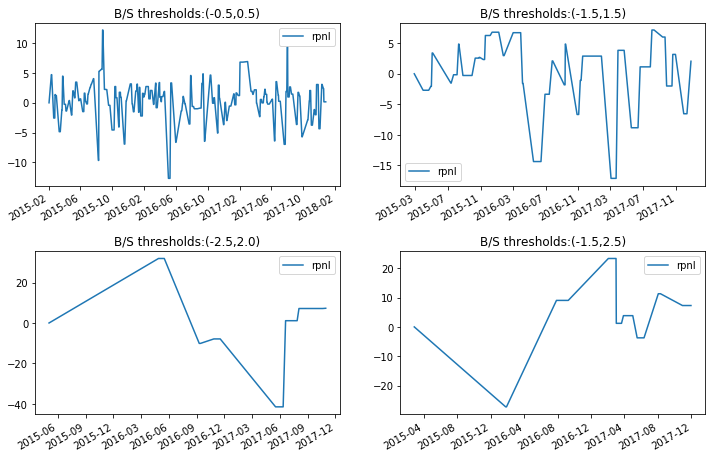

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(THRESHOLDS)//2, 
    ncols=2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.4)
for i, (buy_threshold, sell_threshold) in enumerate(THRESHOLDS):
    engine.start(
        lookback_intervals=20,
        buy_threshold=buy_threshold,
        sell_threshold=sell_threshold
    )
    df_rpnls = engine.df_rpnl
    ax = axes[i // 2, i % 2]
    ax.set_title(
        'B/S thresholds:(%s,%s)' % 
        (buy_threshold, sell_threshold)
    )
    df_rpnls.plot(ax=ax)